# Localization 5

This is my implementation of the Localization part 5 lectures from Lazy Programmer's Deep Learning and Advanced Computer Vision course. In this section a background image is added.

These exercises use a topless, pre-trained VGG16 network as a feature extractor with a small dense layer with four outputs added to output the location of the top, left, width and height of the detected image.

Code for this article can be found at [https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-5.ipynb](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-5.ipynb)

In [129]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image, ImageDraw

IMAGE_DIM = 200

I started with the final code from [Localization 4](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-4.ipynb) and then made the necessary modifications from there.

I want the background image to be different in each image so I grabbed a landscape picture from Unsplash and then updated the LocalizationSequence to take 200x200 pixel sections from the image to use as a background.

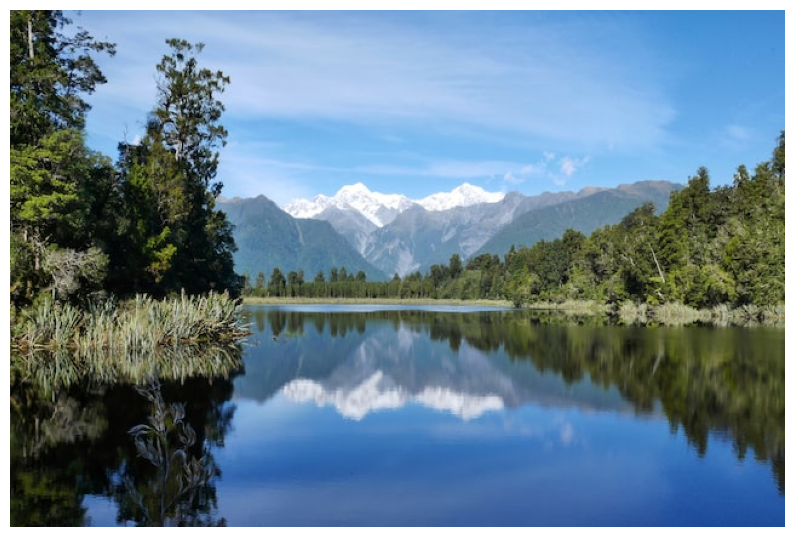

In [130]:
with Image.open('assets/images/landscape.png') as im:
    plt.axis('off')
    plt.imshow(im)

plt.show()

Photo by [Patrick Szylar](https://unsplash.com/@patrick_szylar?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://unsplash.com/s/photos/outdoor?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)

The individual image backgrounds are taken by using the [`Image.crop()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop) function from the Pillow library.

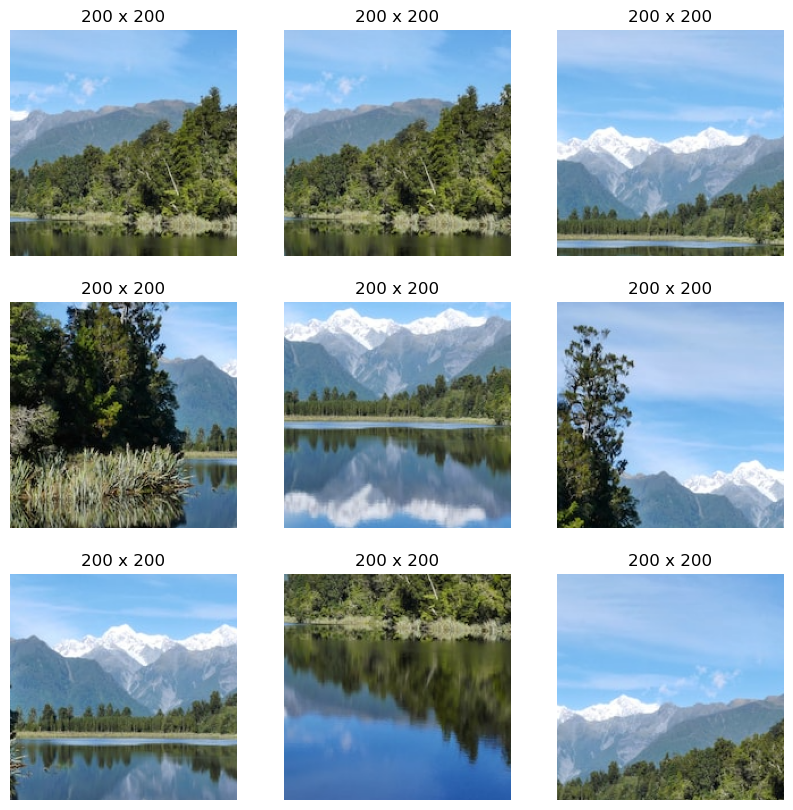

In [131]:
with Image.open('assets/images/landscape.png') as im:
    for i in range(1, 10):
        ax = plt.subplot(3, 3, i)
        left = random.randint(0, im.width - IMAGE_DIM)
        top = random.randint(0, im.height - IMAGE_DIM)
        cropped_im = im.crop((left, top, left + IMAGE_DIM, top + IMAGE_DIM))
        ax.imshow(cropped_im)
        ax.set_axis_off()
        ax.set_title(f'{cropped_im.width} x {cropped_im.height}')
 

plt.show()


To combine the Pokemon and background images together, I used the [`Image.alpha_composite()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.alpha_composite) function from Pillow which ensures that the transparency is respected.

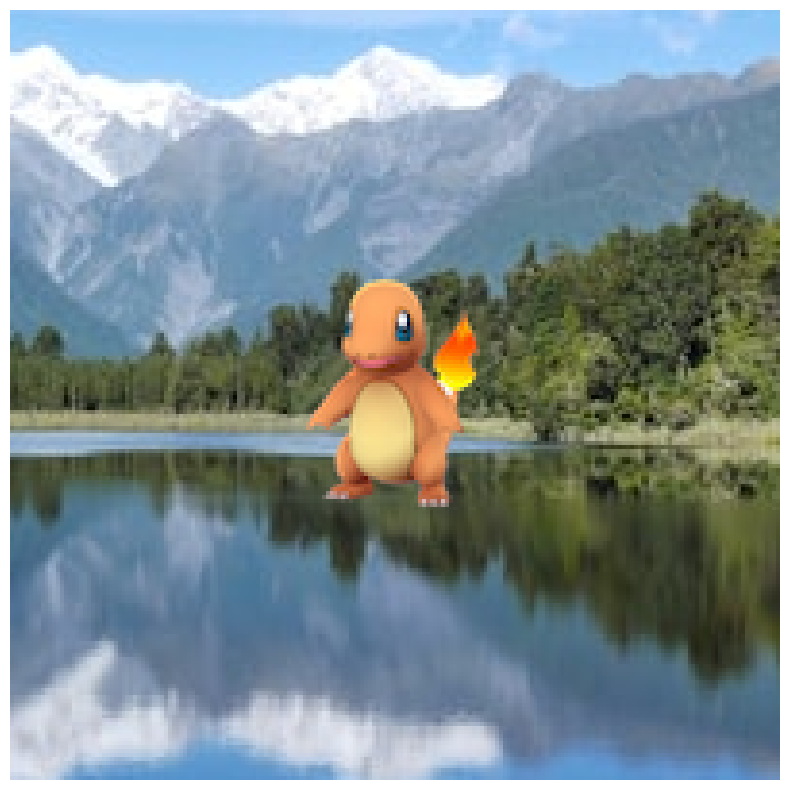

In [132]:
with Image.open('assets/images/landscape.png') as bg, \
     Image.open('assets/images/charmander.png') as im:

    left = random.randint(0, bg.width - IMAGE_DIM)
    top = random.randint(0, bg.height - IMAGE_DIM)
    cropped_bg = bg.crop((left, top, left + IMAGE_DIM, top + IMAGE_DIM))
 
    im_location = (
        int((IMAGE_DIM / 2) - (im.width / 2)), 
        int((IMAGE_DIM / 2) - (im.height / 2))
    )

    combined_image = cropped_bg.alpha_composite(im, dest=im_location)
    
plt.imshow(cropped_bg)
plt.axis('off')
plt.show()


I updated the LocalizationSequence to include a new function for generating the image background. I then updated `generate_image()` to combine the images together.

In [133]:
class LocalizationSequence(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        with Image.open('assets/images/charmander.png') as im, \
             Image.open('assets/images/landscape.png') as bg:
                
            self.charmander = im.copy()
            self.background = bg.copy()
        
        
    def preprocess_y_value(self, y):
        """
        Sets the range of y to 0..1.
        """
        return y / IMAGE_DIM
        

    def generate_background(self):
        """
        Generates a background image by cropping out a part of the
        background image.
        """
        left = random.randint(0, self.background.width - IMAGE_DIM)
        top = random.randint(0, self.background.height - IMAGE_DIM)
        return self.background.crop((left, top, left + IMAGE_DIM, top + IMAGE_DIM))

        
    def generate_charmander(self):
        """
        Generates a Charmander pokemon of a random size from 0.5 to
        1.5 the scale of the original one and flipped left to right
        50% of the time.
        """
        scale = random.uniform(0.5, 1.5)
        poke = self.charmander.resize(
            (int(self.charmander.width * scale), 
             int(self.charmander.height * scale)))

        if random.random() > 0.5:
            poke = poke.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
            
        return poke
        
        
    def generate_image(self):
        """
        Generates a random image with a Charmander inside it. 
        """
        
        # start by generating the background
        img = self.generate_background()
        
        # now generate the pokemon
        poke = self.generate_charmander()
        (char_width, char_height) = poke.size
        
        # place the charminder randomly in the image
        char_left = random.randint(0, img.width - char_width)
        char_top = random.randint(0, img.height - char_height)
        
        # combine the two together
        img.alpha_composite(poke, dest=(char_left, char_top))
        
        # create a numpy array from the image and strip out the
        # alpha channel
        img_arr = np.array(img)[:, :, 0:3]
        
        # normalize colours
        img_arr = img_arr / 255.
        
        return img_arr, self.preprocess_y_value(
            np.array([char_top, char_left, char_height, char_width])
        )
        
        
    def __len__(self):
        """
        We generate the images on the fly so just return the batch size.
        """
        return self.batch_size
    
    
    def __getitem__(self, idx):
        """
        Return a batch of images preprepared for training. I.e. colour ranges
        are 0..1 and not 0..255.
        """
        batch_x = np.empty(
            [self.batch_size, IMAGE_DIM, IMAGE_DIM, 3], 
            dtype=np.float32
        )
        batch_y = np.empty([self.batch_size, 4], dtype=np.float32)
        
        for i in range(self.batch_size):
            batch_x[i], batch_y[i] = self.generate_image()
            
        return batch_x, batch_y
    


Let's test that out and see what it generates.

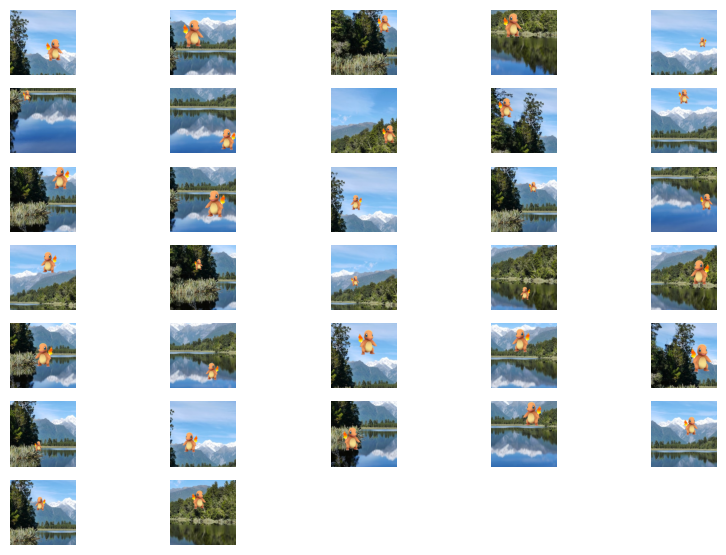

In [134]:
seq = LocalizationSequence(batch_size=32)
batch_x, batch_y = seq.__getitem__(0)

plt.rcParams["figure.figsize"] = (10, 10)
for i in range(min(50, seq.__len__())):
    ax = plt.subplot(10, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(batch_x[i])
    
plt.show()


That all seems to be working fine, so the rest of the code stays the same as it was for the last exercise.

In [135]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [136]:
# create the model
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3), 
    include_top=False, 
    weights='imagenet'
)

# we don't want to train the VGG16 model
vgg16.trainable = False

# create the dense layer
x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(4, activation="sigmoid")(x)

# and build and compile it
model = tf.keras.Model(vgg16.input, x, name="Localization_Model")
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "Localization_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)

In [137]:
history = model.fit(seq, epochs=10)

Epoch 1/10
32/32 [==============================] - 152s 5s/step - loss: 0.6104 - accuracy: 0.6572
Epoch 2/10
32/32 [==============================] - 184s 6s/step - loss: 0.5636 - accuracy: 0.8779
Epoch 3/10
32/32 [==============================] - 188s 6s/step - loss: 0.5558 - accuracy: 0.8877
Epoch 4/10
32/32 [==============================] - 1085s 35s/step - loss: 0.5525 - accuracy: 0.8779
Epoch 5/10
32/32 [==============================] - 181s 6s/step - loss: 0.5590 - accuracy: 0.8838
Epoch 6/10
32/32 [==============================] - 1147s 37s/step - loss: 0.5575 - accuracy: 0.8936
Epoch 7/10
32/32 [==============================] - 1216s 39s/step - loss: 0.5577 - accuracy: 0.9111
Epoch 8/10
32/32 [==============================] - 173s 5s/step - loss: 0.5553 - accuracy: 0.9082
Epoch 9/10
32/32 [==============================] - 180s 6s/step - loss: 0.5548 - accuracy: 0.8945
Epoch 10/10
32/32 [==============================] - 184s 6s/step - loss: 0.5509 - accuracy: 0.9111


Plot the accuracy from the `model.fit()`.

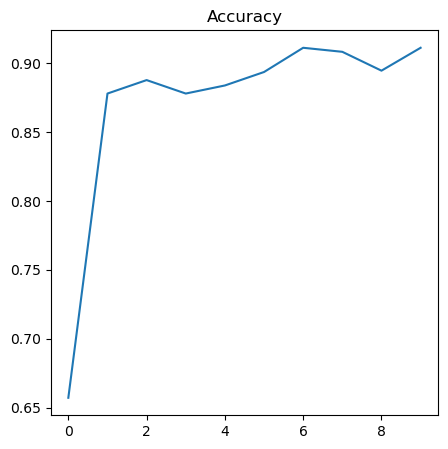

In [138]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.show()

Training can take some time so save out the model so it can be loaded from disk in future.

In [139]:
model.save('saved-models/localization-4.h5', overwrite=True)

The `to_pil_rect()` function takes the y outputs from the model and converts the values into the correct coordinates for the input.

In [140]:
def to_pil_rect(y):
    rv = y * IMAGE_DIM
    rv = np.clip(rv, 1, IMAGE_DIM - 1)
    [top, left, height, width] = rv
    height += top
    width += left
    rv[2] = height
    rv[3] = width
    return rv

The sequence object can be used to create a set of images we can use for prediction.

In [141]:
x, y = seq.__getitem__(0)
print(f'Generated data for predictions: {x.shape}')

Generated data for predictions: (32, 200, 200, 3)


Use the trained model to make some predictions from the new batch.

In [142]:
y_predicted = model.predict(x)

1/1 [==============================] - 6s 6s/step


Create the boxes for both the actual boxes and the predicted ones.

In [143]:
predicted_boxes = np.zeros((seq.batch_size, 4))
actual_boxes = np.zeros((seq.batch_size, 4))

for i, pred in enumerate(y_predicted):
    predicted_boxes[i] = to_pil_rect(pred)
    actual_boxes[i] = to_pil_rect(y[i])

Convert the numpy array into a PIL image so we can work with it as an image.

In [144]:
def add_bounding_boxes():
    rv = np.zeros((seq.batch_size, IMAGE_DIM, IMAGE_DIM, 3), dtype=np.uint8)
    for i in range(seq.batch_size):
        im = Image.fromarray(np.uint8(x[i] * 255), mode='RGB')

        draw = ImageDraw.Draw(im)

        draw.rectangle(
            [actual_boxes[i][1], 
             actual_boxes[i][0], 
             actual_boxes[i][3], 
             actual_boxes[i][2]], outline='yellow')

        draw.rectangle(
            [predicted_boxes[i][1], 
             predicted_boxes[i][0], 
             predicted_boxes[i][3], 
             predicted_boxes[i][2]], outline='green')
        
        rv[i] = np.array(im).astype(dtype=np.uint8)

    return rv

In [145]:
final_images = add_bounding_boxes()

Now we can draw some of the images that were used to create the predictions and overlay the localization rectangles on top of them as before.

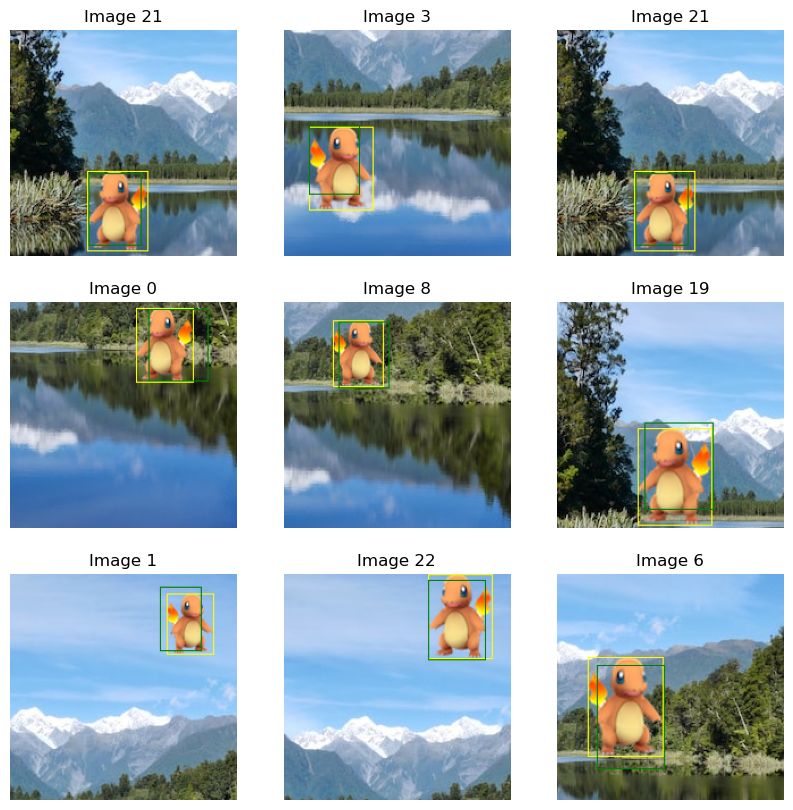

In [146]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im_idx = random.randint(0, seq.batch_size - 1)
    ax.imshow(final_images[im_idx])
    ax.set_axis_off()
    ax.set_title(f'Image {im_idx}')

In the output above you can see the green boxes that are the results of the predictions and the yellow boxes that use the same maths to reverse the sigmoid function and validate that that maths is correct.